# Importações

In [1]:
import torch
from torch import nn
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM,Dense,GRU

import matplotlib.pyplot as plt
import seaborn as sns

#!pip install plotly --upgrade
import plotly.graph_objects as go


# Carregando/Tratando Dados

In [6]:
bicicletas_dados = pd.read_csv("/content/bicicletas.csv")

In [7]:
bicicletas_dados

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


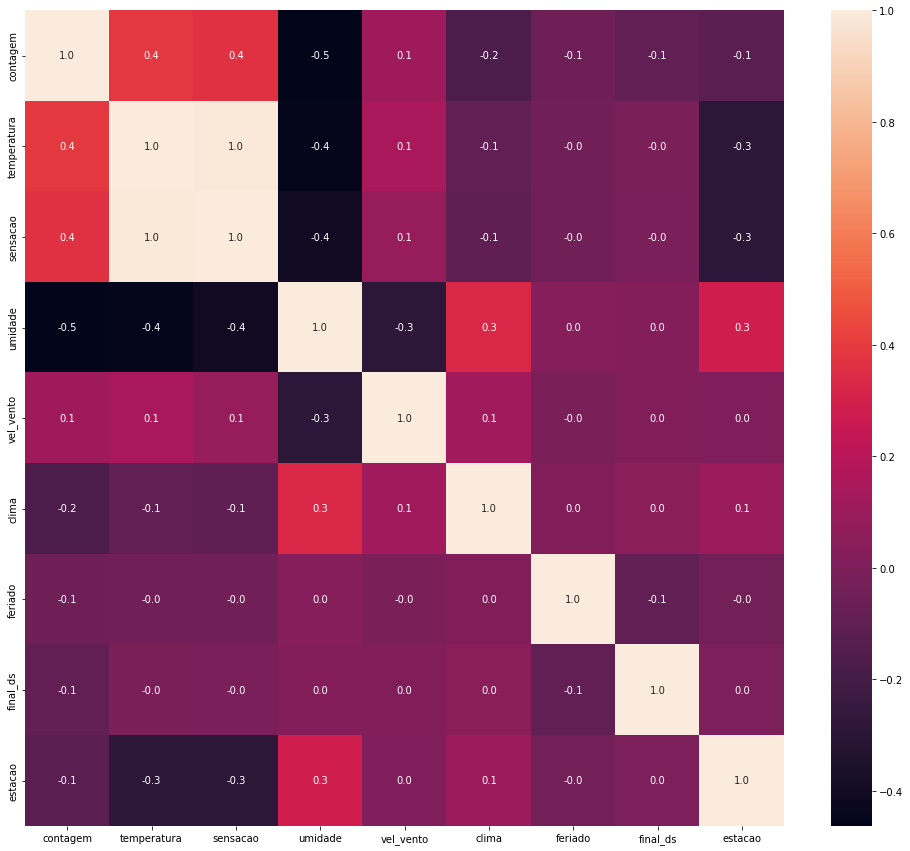

In [8]:
matriz_correlacao = bicicletas_dados.corr()
plt.figure(figsize = (17, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".1f")

In [9]:
bicicletas_dados.isnull().sum()

datas          0
contagem       0
temperatura    0
sensacao       0
umidade        0
vel_vento      0
clima          0
feriado        0
final_ds       0
estacao        0
dtype: int64

In [10]:
bicicletas_dados['datas'] = pd.to_datetime(bicicletas_dados['datas'])

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]), <a list of 9 Text major ticklabel objects>)

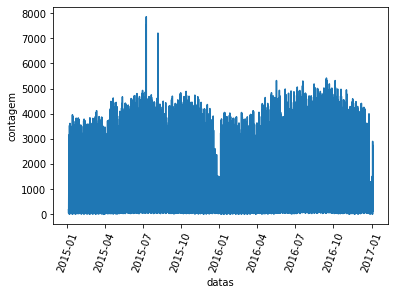

In [11]:
sns.lineplot(x='datas',y='contagem',data = bicicletas_dados);
plt.xticks(rotation=70)

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]), <a list of 9 Text major ticklabel objects>)

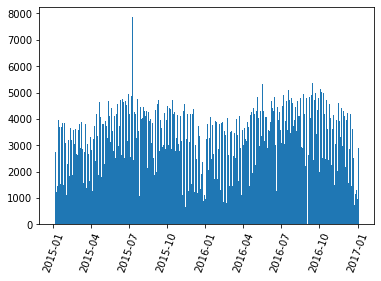

In [12]:
plt.bar(x=bicicletas_dados['datas'].values,height=bicicletas_dados['contagem'].values,)
plt.xticks(rotation=70)

In [13]:
y_= bicicletas_dados['contagem'].values

In [14]:
scaler = StandardScaler()
y_ = scaler.fit_transform(np.reshape(y_,(len(y_),1)))

In [15]:
def voltar_atras(y,n_atras):
  y=list(np.reshape(y,(len(y),)))
  x=[]
  for n,val in enumerate(y):
    if n>=n_atras:
      x.append(y[n-n_atras:n])
  x=np.array(x)
  y=np.array(y[n_atras:])
  return x,y

In [16]:
x,y = voltar_atras(y_,10)

# Separando Treino e Teste

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20,random_state=0,shuffle=True)
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

In [69]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13923, 10)
(13923,)
(3481, 10)
(3481, 1)


# Sklearn

## SVR

In [19]:
svr = SVR()
svr.fit(x_train,y_train)

SVR()

In [20]:
predicoes = svr.predict(x_test)
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))

In [22]:
print(abs(predicoes-y_test).mean())

119.82709928175724


## MLP

In [23]:
mlp = MLPRegressor()
mlp.fit(x_train,y_train)

MLPRegressor()

In [24]:
predicoes = mlp.predict(x_test)
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))


In [26]:
print(abs(predicoes-y_test).mean())

112.1265897907239


# Keras

## MLP

In [27]:
mlp = Sequential()
mlp.add(Dense(128, input_dim=10, kernel_initializer='random_uniform', activation='relu',use_bias=False))
mlp.add(Dense(1, kernel_initializer='random_uniform', activation='linear',use_bias=False))
mlp.compile(loss='mean_squared_error',optimizer='adam')
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 1)                 128       
                                                                 
Total params: 1,408
Trainable params: 1,408
Non-trainable params: 0
_________________________________________________________________


In [28]:
y_test = scaler.transform(np.reshape(y_test,(len(y_test),1)))
resultado = mlp.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=200)
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

Epoch 1/200
436/436 [==============================] - 2s 3ms/step - loss: 0.2909 - val_loss: 0.1174
Epoch 2/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0843 - val_loss: 0.0675
Epoch 3/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0592 - val_loss: 0.0575
Epoch 4/200
436/436 [==============================] - 2s 4ms/step - loss: 0.0530 - val_loss: 0.0513
Epoch 5/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0504 - val_loss: 0.0498
Epoch 6/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0481 - val_loss: 0.0507
Epoch 7/200
436/436 [==============================] - 2s 4ms/step - loss: 0.0475 - val_loss: 0.0460
Epoch 8/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0465 - val_loss: 0.0455
Epoch 9/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0449 - val_loss: 0.0446
Epoch 10/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0449 - val_lo

In [33]:
predicoes = mlp.predict(x_test)

In [34]:
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))

In [35]:
print(abs(predicoes-y_test).mean())

140.26101553060394


## RNN

In [65]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [42]:
recorrente = Sequential()
#recorrente.add(LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))#LSTM ou GRU
#recorrente.add(Dense(units=1))
recorrente.add(GRU(128,input_shape=(x_train.shape[1],x_train.shape[2])))#LSTM ou GRU
recorrente.add(Dense(units=1))

In [43]:
recorrente.compile(loss='mean_squared_error',optimizer='RMSProp')

In [44]:
recorrente.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [46]:
y_test = scaler.transform(np.reshape(y_test,(len(y_test),1)))
resultado = recorrente.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20)
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

Epoch 1/20
436/436 [==============================] - 7s 16ms/step - loss: 0.0412 - val_loss: 2.0360
Epoch 2/20
436/436 [==============================] - 8s 19ms/step - loss: 0.0374 - val_loss: 2.2325
Epoch 3/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0354 - val_loss: 2.0375
Epoch 4/20
436/436 [==============================] - 6s 13ms/step - loss: 0.0341 - val_loss: 2.1207
Epoch 5/20
436/436 [==============================] - 6s 13ms/step - loss: 0.0328 - val_loss: 2.1288
Epoch 6/20
436/436 [==============================] - 6s 13ms/step - loss: 0.0316 - val_loss: 2.1861
Epoch 7/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0313 - val_loss: 2.1976
Epoch 8/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0299 - val_loss: 2.0984
Epoch 9/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0296 - val_loss: 2.2440
Epoch 10/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0290 - val_lo

In [66]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1]))

In [49]:
predicoes = recorrente.predict(x_test)

In [50]:
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

In [51]:
print(abs(predicoes-y_test).mean())

118.72593267914432


# Pytorch

## MLP

In [136]:
class MLP(nn.Module):
  def __init__(self,tam_entrada,tam_hidden,tam_saida):
    super(MLP,self).__init__()
    self.layer0 = nn.Linear(tam_entrada,tam_hidden)
    self.ativ0 = nn.ReLU()
    self.layer1 = nn.Linear(tam_hidden,tam_saida)
  def forward(self,X):
    saida = self.layer1(self.ativ0(self.layer0(X)))
    return saida
modelo = MLP(10,32,1).to(device)

In [147]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(modelo.parameters(),lr=1e-6,weight_decay=1e-4)

In [129]:
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
x_test  = torch.from_numpy(x_test).float().to(device)
y_test  = torch.from_numpy(y_test).float().to(device)

TypeError: ignored

In [148]:
todas_loss=[]
epocas=[]
i=0

In [154]:
modelo.train()
for c in range(100):
  i+=1
  # Forward
  ypred = modelo(x_train)
  loss = criterion(ypred, y_train)

  todas_loss.append(loss.cpu().detach().numpy())
  epocas.append(i)

  # Backpropagation
  loss.backward()
  optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([13923])) that is different to the input size (torch.Size([13923, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [155]:
modelo.eval()
predicoes = modelo(x_test)
predicoes = predicoes.detach().numpy()

In [156]:
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))

In [157]:
predicoes

array([[ 959.1125 ],
       [ 921.4323 ],
       [1104.132  ],
       ...,
       [1006.4205 ],
       [ 740.54663],
       [ 914.86523]], dtype=float32)

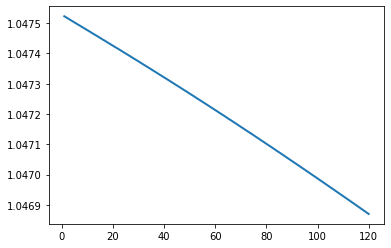

In [158]:
fig, ax = plt.subplots()
ax.plot(epocas, todas_loss, linewidth=2.0)
plt.show()

In [121]:
print(abs(predicoes-y_test.detach().numpy()).mean())

928.45044


## RNN

In [ ]:
class RNN(nn.Module):
  def __init__(self,tam_entrada,tam_hidden,tam_saida):
    super(RNN,self).__init__()
    self.tam_hidden = tam_hidden
    self.recurrent = nn.RNNCell(tam_entrada,tam_hidden)
    self.saida = nn.Linear(tam_hidden,tam_saida)

  def forward(self,dados):
    h = torch.zeros(self.tam_hidden).to(device)
    for dado in dados:
      dado = dado.unsqueeze(0).float()
      h = self.recurrent(dado,h)
    saida = self.saida(h)
    return saida
modelo = RNN(1,28,1).to(device)

In [ ]:
criterion = nn.L1Loss().to(device)
optimizer = torch.optim.Adam(modelo.parameters(),lr=1e-7,weight_decay=1e-5)

In [ ]:
modelo.train()

for epoch in range(10):
  print(f'epoca : {epoch}')
  for n,dado in enumerate(x_train):
    dado = torch.from_numpy(dado).float().to(device)
    rotulo = torch.from_numpy(np.array(y_train[n])).float().unsqueeze(0).to(device)

    saida = modelo(dado)
    loss = criterion(saida, rotulo)
    print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  

In [ ]:
modelo.eval()
for n,dado in enumerate(x_test[0:20]):
    dado = torch.from_numpy(dado).float().to(device)
    rotulo = torch.from_numpy(np.array(y_train[n])).float().unsqueeze(0).to(device)
    saida = modelo(dado)
    print(saida,rotulo)